<img style="float: right;" src="../bvlecture_exercises/htwlogo.jpg">

# Exercise: Classification with FashionMNIST

**Author**: _Erik Rodner_ (adapted from John Bosco)<br>
**Lecture**: Computer Vision and Machine Learning I

In the following notebook, we will learn our first convolutional neural network for image classification.

In [1]:
# import some dependencies
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import OrderedDict
torch.set_printoptions(linewidth=120)

### Defining the dataset

We will use the FashionMNIST dataset. ``pytorch`` already contains some helper functions that download
the dataset (if it is not available locally). Furthermore, the dataset splits are already given for training
and testing. The ``transform`` parameter defines a function that takes an PIL image and preprocesses it to the input for the network. If you want to add pre-processing, you could use a compose statement and further operations: ``transforms.Compose([.., transforms.ToTensor()]``, but for now we simply transform it to a tensor.

In [2]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=True,
                                              transform=transforms.ToTensor())

test_set = torchvision.datasets.FashionMNIST(root="./", download=True, 
                                              train=False,
                                              transform=transforms.ToTensor())

Now, let's define the data loader, as usual: batching and shuffling

In [3]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)

Let us take a single example and visualize it.

In [4]:
# Take a single batch
sample = next(iter(data_loader))
imgs, lbls = sample

image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([0, 8, 6, 4, 4, 9, 4, 4, 8, 0])


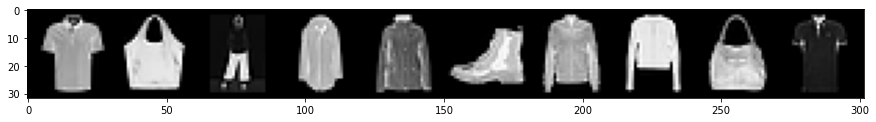

In [5]:
# create a grid 
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

### Additional helper functions

Let's define some helper functions to compute all predictions on a given dataset and to count the number of correctly classified examples.

In [6]:
# define some helper functions
def count_correct_samples(preds, labels):
    """function that returns the accuracy of our architecture"""
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad() # turn off gradients during inference for memory efficiency
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in dataloader:
        images, labels = batch
        preds = network(images) # get preds
        all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis
        all_labels = torch.cat((all_labels, labels), dim=0) # join along existing axis
        
    return all_preds, all_labels

### Defining the model 

Similar to our *Where is Waldo* exercise, we define our model as an ``nn.Module``.

In [22]:
# define network

class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        # The FasionMNIST dataset is grayscale, therefore we have an in_channels parameter
        # of the first layer of 1
        
        self.layers = [
             ("conv1", nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(5,5))),
             ("maxpool1", nn.AvgPool2d(kernel_size=2, stride=2)),
             ("relu1", nn.ReLU()),
             ("conv2", nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(5,5))),
             ("maxpool2", nn.AvgPool2d(kernel_size=2, stride=2)),
             ("relu2", nn.ReLU()),
             # fully-connected part
             ("flatten", nn.Flatten()),
             ("fc1", nn.Linear(in_features=12*4*4, out_features=12)),
             ("relu3", nn.ReLU()),
             ("fc2", nn.Linear(in_features=12, out_features=6)),
             ("relu4", nn.ReLU()),
             ("out", nn.Linear(in_features=6, out_features=10)) ]
        
        self.seq = torch.nn.Sequential( OrderedDict(self.layers) )
        
        
    def forward(self, t): # forward!
        return self.seq(t) 

In [23]:
# Define the data loader and the batch size
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)

### Training optimization

In [24]:
cnn_model = Network() # init model
optimizer = optim.Adam(lr=0.001, params=cnn_model.parameters())
# def train loop

for epoch in range(5):
    start_time = time.time()
    total_correct = 0
    total_loss = 0
    for batch in data_loader:
        imgs, lbls = batch
        preds = cnn_model(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # compute loss
        optimizer.zero_grad() # zero grads
        loss.backward() # calculates gradients 
        optimizer.step() # update the weights
        
        total_loss += loss.item()
        total_correct += count_correct_samples(preds, lbls)
        accuracy = total_correct/len(train_set)
    end_time = time.time() - start_time    
    print(f"Epoch no. {epoch+1}|training accuracy: {accuracy*100:.3f}% |total_loss: {total_loss} |epoch_duration: {end_time:.2f}sec")

Epoch no. 1|training accuracy: 31.080% |total_loss: 868.757627248764 |epoch_duration: 8.71sec
Epoch no. 2|training accuracy: 55.002% |total_loss: 567.208075761795 |epoch_duration: 9.61sec
Epoch no. 3|training accuracy: 59.393% |total_loss: 485.6745592355728 |epoch_duration: 9.55sec
Epoch no. 4|training accuracy: 63.665% |total_loss: 453.8223435282707 |epoch_duration: 9.41sec
Epoch no. 5|training accuracy: 64.547% |total_loss: 434.2091941833496 |epoch_duration: 9.73sec


### Evaluation

Let's evaluate our classifier on the predefined test set. Define a data loader for convenience first:

In [25]:
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=1)

Now, get all predictions at once

In [26]:
preds, labels = get_all_preds(cnn_model, data_loader_test)
preds_discrete_np = np.array(preds.argmax(dim=1))
labels_np = np.array(labels)

Compute accuracies and the confusion matrix

In [27]:
cm = confusion_matrix(labels_np, preds_discrete_np)
total_accuracy = np.sum(np.diag(cm))/len(labels_np)
class_accuracies = np.diag(cm)/np.sum(cm, axis=1)
print (f"Standard accuracy: {total_accuracy*100:.2f}%")
print (f"Class accuracies: {class_accuracies}")

Standard accuracy: 65.01%
Class accuracies: [0.694 0.907 0.028 0.528 0.644 0.829 0.193 0.872 0.903 0.903]


... and display the confusion matrix

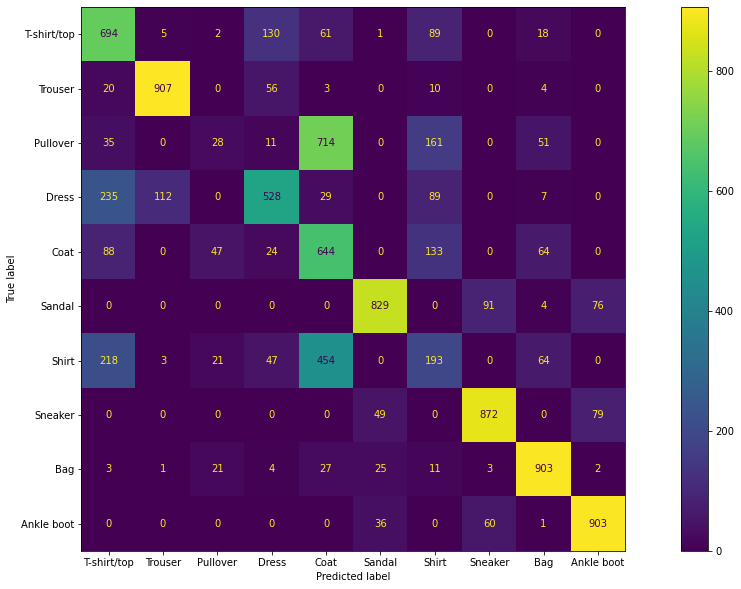

In [28]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set.classes)
plt.figure(figsize=(20,10))
disp.plot(ax=plt.gca())